In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler
import h2o
from h2o.automl import H2OAutoML
from keras.models import load_model
import seaborn as sns
import keras
import h5py
import requests
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import HuberRegressor

In [66]:
train = []

test = pd.read_csv('/kaggle/input/kriti-old-dataset/kaggle-stock-market-prediction/test.csv')
test['Date'] = pd.to_datetime(test.Date)
sub1 = pd.DataFrame(test['Id'])
sub1['Close'] = np.nan
test.drop(['Id'], axis=1, inplace=True)
test['is_test'] = 1 # we will be combining train and test dataframes

for i in range(4):
    train.append(pd.read_csv('/kaggle/input/kriti-old-dataset/kaggle-stock-market-prediction/'+f'{i+1}_train.csv'))
    train[i]['Date'] = pd.to_datetime(train[i].Date)
    train[i]['Company'] = i+1
    train[i]['is_test'] = 0 
    train[i] = pd.concat([train[i], test[test['Company'] == i+1]])
    train[i].sort_values(by='Date', inplace = True)
    train[i].drop(['Company'], axis=1, inplace=True)

In [67]:
train[0].head()

,Date,Open,High,Low,Close,Adj Close,Volume,is_test
0,2010-06-29,9.50,9.47,9.23,9.12,7.93,1.133345e+09,0
1,2010-06-30,9.25,9.22,9.00,9.04,7.52,7.394520e+08,0
2,2010-07-01,9.01,9.02,8.63,8.70,7.45,1.022896e+09,0
3,2010-07-02,8.98,8.96,8.74,8.94,7.68,6.938428e+08,0
4,2010-07-06,9.13,9.13,8.61,8.85,7.68,6.152356e+08,0


# Data Preprocessing

In [68]:
# Creating leads using next day's open price
for i in range(4):
    train[i]['Lead_Open_1'] = train[i]['Open'].shift(-1)
    train[i].at[train[i].index[-1], 'Lead_Open_1'] = train[i].iloc[-1, :]['Adj Close']

In [69]:
# Creating lags using last 15 days Open prices, Adj Close prices
for i in range(4):
    for j in range(15):
        train[i][f'Lag_Open_{j+1}'] = train[i]['Open'].shift(j+1)
        train[i][f'Lag_Adj_Close_{j+1}'] = train[i]['Adj Close'].shift(j+1)    

In [70]:
# Creating a feature of sum of last 2 days Volume
for i in range(4):
    for j in range(2):
        train[i][f'Lag_Volume_{j+1}'] = train[i]['Volume'].shift(j+1)
    train[i]['Lag_Volume'] = train[i]['Lag_Volume_1'] + train[i]['Lag_Volume_2']
    train[i].drop(['Lag_Volume_1', 'Lag_Volume_2'], axis=1, inplace=True)

In [71]:
# Creating lags using last 15 days High and Low price and Volume
for i in range(4):
    for j in range(15):
        train[i][f'Lag_Volume_{j+1}'] = train[i]['Volume'].shift(j+1)
        train[i][f'Lag_High_{j+1}'] = train[i]['High'].shift(j+1)
        train[i][f'Lag_Low_{j+1}'] = train[i]['Low'].shift(j+1)  

In [72]:
# Creating features Day of Week(removed), Date of Month(removed), Week of Year, Month, Year
for i in range(4):
    train[i]['Day_of_Week'] = train[i]['Date'].dt.dayofweek
    train[i]['Date_of_Month'] = train[i]['Date'].dt.day
    train[i]['Week_of_Year'] = train[i]['Date'].dt.week
    train[i]['Month'] = train[i]['Date'].dt.month
    train[i]['Year'] = train[i]['Date'].dt.year

In [73]:
# Creating features Quarter, (is_month_start, is_month_end, is_quarter_start, is_quarter_end, is_year_end)(removed)

for i in range(4):
    train[i]['Quarter_of_Year'] = train[i]['Date'].dt.quarter
    train[i]['is_month_start'] = train[i]['Date'].dt.is_month_start.astype(int)
    train[i]['is_month_end'] = train[i]['Date'].dt.is_month_end.astype(int)
    train[i]['is_quarter_start'] = train[i]['Date'].dt.is_quarter_start.astype(int)
    train[i]['is_quarter_end'] = train[i]['Date'].dt.is_quarter_end.astype(int)
    train[i]['is_year_end'] = train[i]['Date'].dt.is_year_end.astype(int)

In [74]:
# Adding feature (High+Low)/2, (High*Low)**0.5
for i in range(4):
    train[i]['HighnLow'] = (train[i]['High'] + train[i]['Low'])/2
    train[i]['sqrtHighLow'] = (train[i]['High']*train[i]['Low'])**0.5

In [75]:
# Creating feature using scaled volume
for i in range(4):
    scaler = MinMaxScaler()
    volume_scaled = scaler.fit_transform(pd.DataFrame(train[i]['Volume']))
    train[i]['Volume_scaled'] = volume_scaled
    train[i].drop(['Volume'], 1, inplace=True)

#### Handling cyclic features like month
Doesn't work for day of week, date of month, month, week of year, graph comes linear not circular

<Figure size 432x288 with 0 Axes>

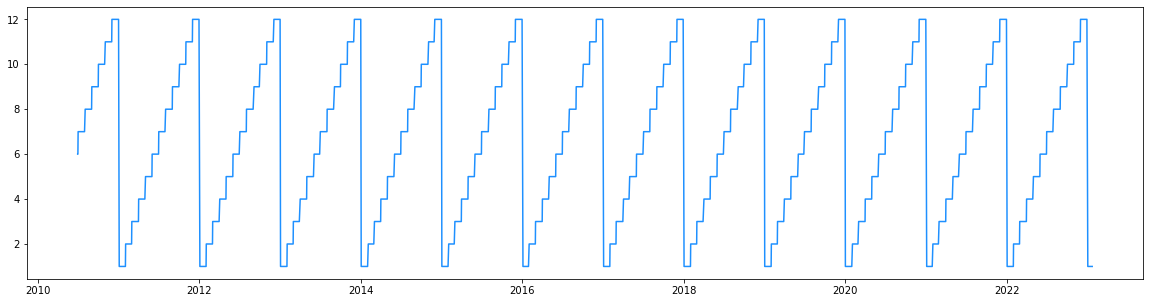

<Figure size 432x288 with 0 Axes>

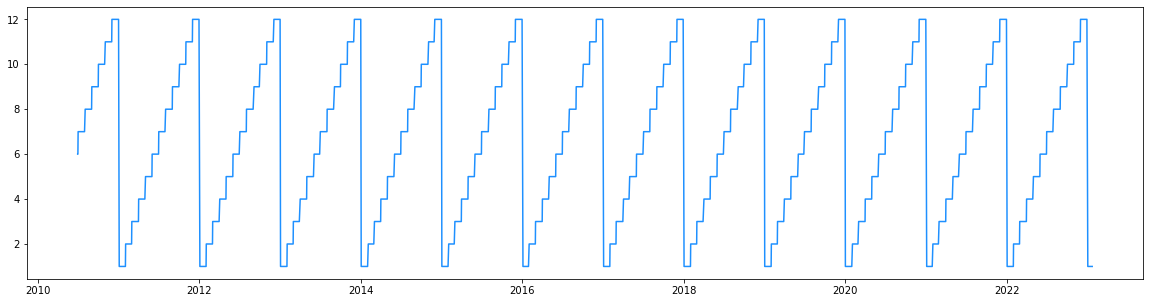

<Figure size 432x288 with 0 Axes>

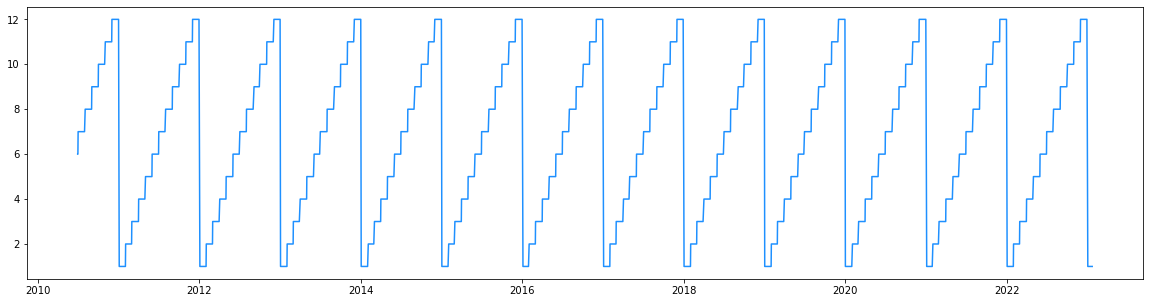

<Figure size 432x288 with 0 Axes>

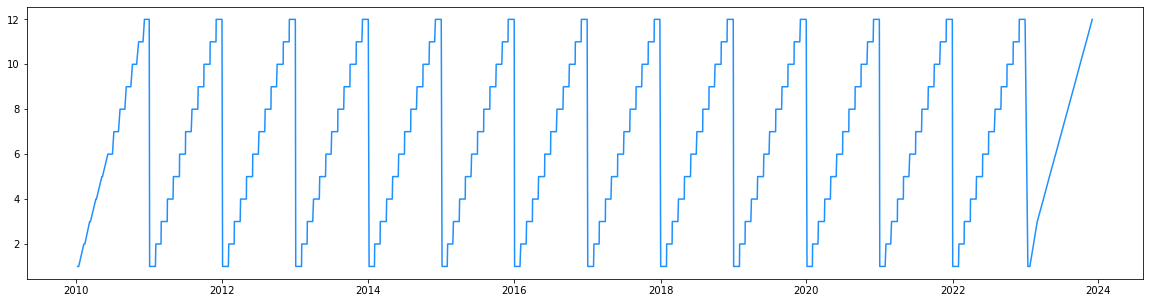

In [76]:
import matplotlib.pyplot as plt

for i in range(4):
    plt.figure()
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    ax.plot(train[i]['Date'], train[i]['Month'], color='dodgerblue')
    # ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    plt.show()

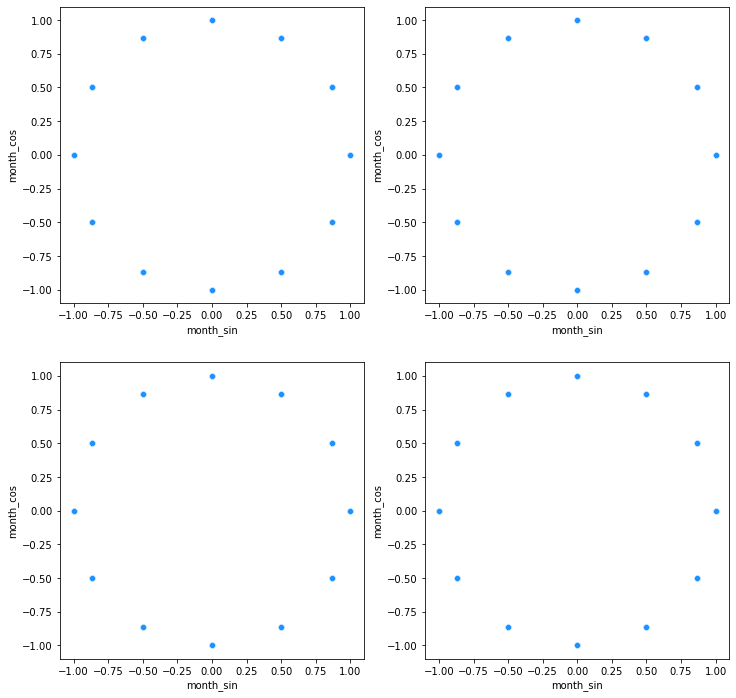

In [77]:
month_in_year = 12

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

for i in range(4):
    day_in_week = train[i]['Day_of_Week'].nunique()
    date_in_month = train[i]['Date_of_Month'].nunique()
    week_in_year = train[i]['Week_of_Year'].nunique()
    
    train[i]['month_sin'] = np.sin(2*np.pi*train[i]['Month']/month_in_year)
    train[i]['month_cos'] = np.cos(2*np.pi*train[i]['Month']/month_in_year)
    train[i]['day_sin'] = np.sin(2*np.pi*train[i]['Day_of_Week']/day_in_week)
    train[i]['day_cos'] = np.sin(2*np.pi*train[i]['Day_of_Week']/day_in_week)
    train[i]['date_sin'] = np.sin(2*np.pi*train[i]['Date_of_Month']/date_in_month)
    train[i]['date_cos'] = np.sin(2*np.pi*train[i]['Date_of_Month']/date_in_month)
    train[i]['week_sin'] = np.sin(2*np.pi*train[i]['Week_of_Year']/week_in_year)
    train[i]['week_cos'] = np.sin(2*np.pi*train[i]['Week_of_Year']/week_in_year)
    sns.scatterplot(x=train[i].month_sin, y=train[i].month_cos, color='dodgerblue', ax=ax[i//2][i%2])

plt.show()

In [78]:
train[0].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'is_test',
       'Lead_Open_1', 'Lag_Open_1', 'Lag_Adj_Close_1',
       ...
       'sqrtHighLow', 'Volume_scaled', 'month_sin', 'month_cos', 'day_sin',
       'day_cos', 'date_sin', 'date_cos', 'week_sin', 'week_cos'],
      dtype='object', length=106)

In [79]:
# Dropping the Date, Month
# Moving the Close column to the right

for i in range(4):
    train[i].drop(['Date', 'Month'], axis=1, inplace=True)
    train[i] = train[i].reindex(columns = [col for col in train[i].columns if col != 'Close'] + ['Close'])

In [80]:
# Drop the rows containing null values created due to creation of lags
for i in range(4):
    print(len(train[0][train[0][train[0]['is_test'] == 0].isna().sum(axis=1)>0]))

15
15
15
15


Therefore, first 15 rows of each dataframes need to be dropped

In [81]:
for i in range(4):
    train[i] = train[i].iloc[15:]
    print(len(train[0][train[0][train[0]['is_test'] == 0].isna().sum(axis=1)>0])) # check if these rows have been dropped successfully

0
0
0
0


In [82]:
train[0].columns

Index(['Open', 'High', 'Low', 'Adj Close', 'is_test', 'Lead_Open_1',
       'Lag_Open_1', 'Lag_Adj_Close_1', 'Lag_Open_2', 'Lag_Adj_Close_2',
       ...
       'Volume_scaled', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'date_sin', 'date_cos', 'week_sin', 'week_cos', 'Close'],
      dtype='object', length=104)

#### Data preprocessing is handled 🎉

#### MI score for feature selection and creation

In [83]:
tests = []
for i in range(4):
    tests.append(train[i][train[i]['is_test'] == 1])
    train[i] = train[i][train[i]['is_test'] == 0]
    tests[i].drop(['is_test'], axis=1, inplace=True)
    train[i].drop(['is_test'], axis=1, inplace=True)

In [84]:
from sklearn.feature_selection import mutual_info_regression

mi_score = []

for i in range(4):
    mi_score.append(mutual_info_regression(train[i].drop(['Close'], 1), train[i]['Close']))

In [85]:
cols_to_drop = []
for i in range(4):  
    inner_list = []
    print(f"=======Company {i+1}=======")
    for j in range(len(train[i].columns)-1):
        if mi_score[i][j]<2.2:
            inner_list.append(train[i].columns[j])
            print(train[i].columns[j], ":", mi_score[i][j])
    cols_to_drop.append(inner_list)

=======Company 1=======
Lag_Volume : 0.6453801235487227
Lag_Volume_1 : 0.5771445744150006
Lag_Volume_2 : 0.5653616516515534
Lag_Volume_3 : 0.5542193638079222
Lag_Volume_4 : 0.551943739509742
Lag_Volume_5 : 0.5603458115263802
Lag_Volume_6 : 0.5509218128881868
Lag_Volume_7 : 0.5787399711272085
Lag_Volume_8 : 0.5454192218578138
Lag_Volume_9 : 0.5441560943721537
Lag_Volume_10 : 0.5414238769606907
Lag_Volume_11 : 0.5441245010418498
Lag_Volume_12 : 0.5589669969896125
Lag_Volume_13 : 0.5621104452409886
Lag_Volume_14 : 0.5538987917800773
Lag_Volume_15 : 0.5410154388085466
Day_of_Week : 0.0
Date_of_Month : 0.0
Week_of_Year : 1.2367770007255765
Year : 1.7514744782381575
Quarter_of_Year : 0.45265351482873006
is_month_start : 0.0
is_month_end : 0.0
is_quarter_start : 0.0
is_quarter_end : 0.0
is_year_end : 0.001255349225138036
Volume_scaled : 0.5556724425203425
month_sin : 0.539082717984336
month_cos : 0.4924866316071115
day_sin : 0.0
day_cos : 0.0
date_sin : 0.0
date_cos : 0.0
week_sin : 1.1423483

In [86]:
# Dropping the above listed features
for i in range(4):
    train[i].drop(cols_to_drop[i], 1, inplace=True)
    tests[i].drop(cols_to_drop[i], 1, inplace=True)

In [87]:
train[0].head()

,Open,High,Low,Adj Close,Lead_Open_1,Lag_Open_1,Lag_Adj_Close_1,Lag_Open_2,Lag_Adj_Close_2,Lag_Open_3,...,Lag_Low_12,Lag_High_13,Lag_Low_13,Lag_High_14,Lag_Low_14,Lag_High_15,Lag_Low_15,HighnLow,sqrtHighLow,Close
15,9.67,9.44,9.12,7.75,9.07,8.63,7.63,8.86,7.49,8.92,...,8.74,9.02,8.63,9.22,9.00,9.47,9.23,9.280,9.278621,8.97
16,9.07,9.30,8.97,8.01,9.25,9.67,7.75,8.63,7.63,8.86,...,8.61,8.96,8.74,9.02,8.63,9.22,9.00,9.135,9.133510,9.22
17,9.25,9.31,9.14,7.93,9.24,9.07,8.01,9.67,7.75,8.63,...,8.99,9.13,8.61,8.96,8.74,9.02,8.63,9.225,9.224608,9.30
18,9.24,9.34,9.33,7.95,9.61,9.25,7.93,9.07,8.01,9.67,...,9.09,9.36,8.99,9.13,8.61,8.96,8.74,9.335,9.334999,9.06
19,9.61,9.51,9.27,8.09,9.43,9.24,7.95,9.25,7.93,9.07,...,8.95,9.38,9.09,9.36,8.99,9.13,8.61,9.390,9.389233,9.56


In [88]:
corrs = []
for i in range(4):
    corrs.append(train[i].corr())

In [89]:
corrs[0][abs(corrs[0]['Close'])<0.1]

,Open,High,Low,Adj Close,Lead_Open_1,Lag_Open_1,Lag_Adj_Close_1,Lag_Open_2,Lag_Adj_Close_2,Lag_Open_3,...,Lag_Low_12,Lag_High_13,Lag_Low_13,Lag_High_14,Lag_Low_14,Lag_High_15,Lag_Low_15,HighnLow,sqrtHighLow,Close


# Train Val Test Split

In [90]:
from sklearn.model_selection import train_test_split

X_train = []
y_train = []
X_val = []
y_val = []

for i in range(4):

#     X_train.append(train[i].drop(['Close'], 1))
#     y_train.append(train[i]['Close'])
# # Uncomment this and comment out the below part if you want to use entire data for training, i.e. val_size=0

    X1, X2, y1, y2 = train_test_split(train[i].drop(['Close'], axis=1),
                                                        train[i]['Close'],
                                                        test_size=0.2,
                                                        random_state=42)
    X_train.append(X1)
    X_val.append(X2)
    y_train.append(y1)
    y_val.append(y2)
    

In [91]:
X_train[0].shape, train[0].shape

((2012, 67), (2516, 68))

# Model Building / Training

In [92]:
models = []
train_actual = [] # y values of the train set
val_actual = [] # y values of the validation set
train_preds = [] # predictions of the model
val_preds = []

for i in range(4):
    model = LinearRegression()
    model.fit(X_train[i], y_train[i])
    models.append(model)
    print(f"TRAIN RMSE (Company {i+1}): ", mean_squared_error(model.predict(X_train[i]), y_train[i])**0.5)
    print(f"VALIDATION RMSE (Company {i+1}): ", mean_squared_error(model.predict(X_val[i]), y_val[i])**0.5)
    train_preds.append(model.predict(X_train[i]))
    val_preds.extend(model.predict(X_val[i]))
    train_actual.append(y_train[i])
    val_actual.extend(y_val[i])

TRAIN RMSE (Company 1):  0.146716488130011
VALIDATION RMSE (Company 1):  0.15391334375469898
TRAIN RMSE (Company 2):  0.13430786579705759
VALIDATION RMSE (Company 2):  0.13017849428829312
TRAIN RMSE (Company 3):  0.14850092510080143
VALIDATION RMSE (Company 3):  0.15324504080437812
TRAIN RMSE (Company 4):  0.13726157770090874
VALIDATION RMSE (Company 4):  0.13998136976932932


In [93]:
# Calculating overall scores of all 4 companies combined
print(f"OVERALL TRAIN RMSE: ", mean_squared_error(train_actual, train_preds)**0.5)
print(f"OVERALL VALIDATION RMSE: ", mean_squared_error(val_actual, val_preds)**0.5)

OVERALL TRAIN RMSE:  0.14182524120629986
OVERALL VALIDATION RMSE:  0.14466736343639547


In [94]:
test_preds = []

# Generating test predictions
for i in range(4):
    test_preds.extend(models[i].predict(tests[i].drop(['Close'], axis=1)))

##### Creating submission file

In [95]:
sub1['Id'] = test.sort_values(by=['Company', 'Date']).index
sub1['Close'] = test_preds
sub1.head()

,Id,Close
0,1266,98.234628
1,1267,97.094807
2,1268,97.426891
3,1269,92.959033
4,1270,92.183381


# Second Approach
We keep only Adj Close feature to predict the Close price.

In [105]:
train = []

test = pd.read_csv('/kaggle/input/kriti-old-dataset/kaggle-stock-market-prediction/test.csv')
test['Date'] = pd.to_datetime(test.Date)
sub2 = pd.DataFrame(test['Id'])
sub2['Close'] = np.nan
test.drop(['Id'], axis=1, inplace=True)
test['is_test'] = 1 # we will be combining train and test dataframes

for i in range(4):
    train.append(pd.read_csv('/kaggle/input/kriti-old-dataset/kaggle-stock-market-prediction/'+f'{i+1}_train.csv'))
    train[i]['Date'] = pd.to_datetime(train[i].Date)
    train[i]['Company'] = i+1
    train[i]['is_test'] = 0 
    train[i] = pd.concat([train[i], test[test['Company'] == i+1]])
    train[i].sort_values(by='Date', inplace = True)
    train[i].drop(['Company'], axis=1, inplace=True)

In [106]:
tests = []
for i in range(4):
    tests.append(train[i][train[i]['is_test'] == 1])
    train[i] = train[i][train[i]['is_test'] == 0]
    tests[i].drop(['is_test'], axis=1, inplace=True)
    train[i].drop(['is_test'], axis=1, inplace=True)

In [107]:
from sklearn.model_selection import train_test_split

X_train = []
y_train = []
X_val = []
y_val = []

for i in range(4):
    X1, X2, y1, y2 = train_test_split(pd.DataFrame(train[i]['Adj Close']),
                                                        train[i]['Close'],
                                                        test_size=0.2,
                                                        random_state=42)
    X_train.append(X1)
    X_val.append(X2)
    y_train.append(y1)
    y_val.append(y2)

In [108]:
models = []
train_actual = [] # y values of the train set
val_actual = [] # y values of the validation set
train_preds = [] # predictions of the model
val_preds = []

for i in range(4):
    model = LinearRegression()
    model.fit(X_train[i], y_train[i])
    models.append(model)
    print(f"TRAIN RMSE (Company {i+1}): ", mean_squared_error(model.predict(X_train[i]), y_train[i])**0.5)
    print(f"VALIDATION RMSE (Company {i+1}): ", mean_squared_error(model.predict(X_val[i]), y_val[i])**0.5)
    train_preds.append(model.predict(X_train[i]))
    val_preds.extend(model.predict(X_val[i]))
    train_actual.append(y_train[i])
    val_actual.extend(y_val[i])

TRAIN RMSE (Company 1):  0.5084592284182294
VALIDATION RMSE (Company 1):  0.5088696642151214
TRAIN RMSE (Company 2):  0.1377162863315181
VALIDATION RMSE (Company 2):  0.13688974881889773
TRAIN RMSE (Company 3):  0.17755032474844815
VALIDATION RMSE (Company 3):  0.1735386734684309
TRAIN RMSE (Company 4):  0.14221767721174064
VALIDATION RMSE (Company 4):  0.13681978763672328


In [109]:
# Calculating overall scores of all 4 companies combined
print(f"OVERALL TRAIN RMSE: ", mean_squared_error(train_actual, train_preds)**0.5)
print(f"OVERALL VALIDATION RMSE: ", mean_squared_error(val_actual, val_preds)**0.5)

OVERALL TRAIN RMSE:  0.2869000470609878
OVERALL VALIDATION RMSE:  0.28571072082101334


In [110]:
test_preds = []

# Generating test predictions
for i in range(4):
    test_preds.extend(models[i].predict(pd.DataFrame(tests[i]['Adj Close'])))

In [111]:
sub2['Id'] = test.sort_values(by=['Company', 'Date']).index
sub2['Close'] = test_preds
sub2.head()

,Id,Close
0,1266,97.940116
1,1267,96.784549
2,1268,97.011712
3,1269,92.596853
4,1270,92.517840


# Ensembling
We used Simple Average ensembling to combine the predictions of both models.

In [115]:
sub_final = pd.DataFrame(sub1['Id'])
sub_final['Close'] = 0.55*sub1['Close']+0.45*sub2['Close']
sub_final.head()

,Id,Close
0,1266,98.102098
1,1267,96.955191
2,1268,97.240061
3,1269,92.796052
4,1270,92.333888


In [116]:
sub_final.to_csv('submission.csv')

# Done 🎉